In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import folium

# Step 1: Identify neighbours

In [2]:
# Haversine formula 
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius (km)
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

# Load stations 
# Reading only the necessary columns, then keep unique stations
stations = pd.read_csv("weather_data2.csv", usecols=["station_id","latitude","longitude"]).drop_duplicates()


# ---- Build adjacency list ----
cutoff_km = 4.0
adj = {}
for i, s1 in stations.iterrows():
    neigh = []
    for j, s2 in stations.iterrows():
        if s1.station_id == s2.station_id:
            continue
        d = haversine_km(s1.latitude, s1.longitude, s2.latitude, s2.longitude)
        if d <= cutoff_km:
            neigh.append((s2.station_id, round(d,3)))
    adj[s1.station_id] = neigh

# ---- Store neighbour info in dataframe ----
stations["neighbours"] = stations["station_id"].map(lambda sid: [n[0] for n in adj[sid]])
stations["neighbour_count"] = stations["neighbours"].apply(len)

# ---- Export adjacency list ----
edges = []
for sid, neigh_list in adj.items():
    for n_id, dist in neigh_list:
        edges.append({"station_a": sid, "station_b": n_id, "distance_km": dist})

edges_df = pd.DataFrame(edges)
#stations.to_csv("stations_with_neighbours.csv", index=False)
#edges_df.to_csv("station_edges_within4km.csv", index=False)

print("✅ Done — neighbours computed using Haversine (cutoff=4 km)")

✅ Done — neighbours computed using Haversine (cutoff=4 km)


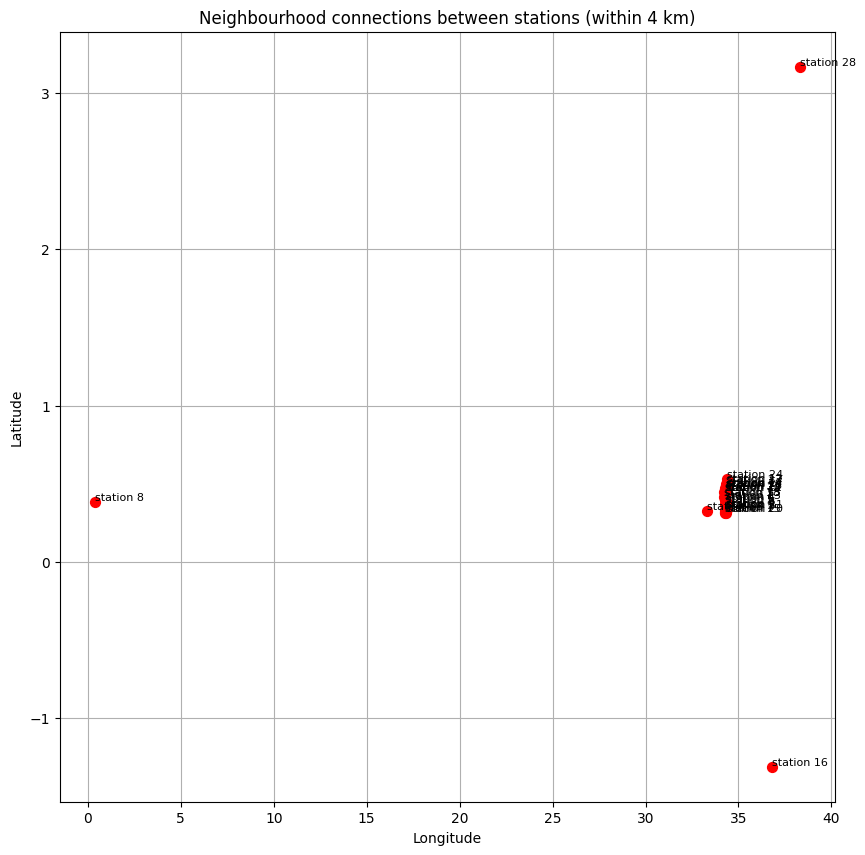

In [4]:
# Merge edges_df with stations to get coordinates for plotting lines
edges_plot = edges_df.merge(
    stations[["station_id", "latitude", "longitude"]],
    left_on="station_a", right_on="station_id"
).rename(columns={"latitude": "lat_a", "longitude": "lon_a"})

edges_plot = edges_plot.merge(
    stations[["station_id", "latitude", "longitude"]],
    left_on="station_b", right_on="station_id"
).rename(columns={"latitude": "lat_b", "longitude": "lon_b"})

# Plot
plt.figure(figsize=(10, 10))

# Plot edges (blue lines)
for _, row in edges_plot.iterrows():
    plt.plot([row.lon_a, row.lon_b], [row.lat_a, row.lat_b], color="blue", alpha=0.5)

# Plot stations (red dots)
plt.scatter(stations["longitude"], stations["latitude"], color="red", s=50, zorder=3)

# Add labels
for _, row in stations.iterrows():
    plt.text(row["longitude"]+0.01, row["latitude"]+0.01, row["station_id"], fontsize=8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Neighbourhood connections between stations (within 4 km)")
plt.grid(True)
plt.show()

In [5]:
# Center map on Busia region (roughly around average lat/lon)
m = folium.Map(location=[stations["latitude"].mean(), stations["longitude"].mean()], zoom_start=10)

# Add stations
for _, row in stations.iterrows():
    color = "green" if row["neighbour_count"] > 0 else "red"  # Red for isolated stations
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5 + row["neighbour_count"],  # bigger if more neighbours
        color="black",
        weight=1,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Station: {row['station_id']}<br>Neighbours: {row['neighbour_count']}"
    ).add_to(m)

# Add edges (neighbour connections)
for _, row in edges_df.iterrows():
    s1 = stations.loc[stations["station_id"] == row["station_a"]].iloc[0]
    s2 = stations.loc[stations["station_id"] == row["station_b"]].iloc[0]
    folium.PolyLine(
        locations=[[s1["latitude"], s1["longitude"]], [s2["latitude"], s2["longitude"]]],
        color="blue", weight=1, opacity=0.5
    ).add_to(m)
m


- Based on the above output, the following stations will be excluded from the study: Station 16, Station 23, Station 24, Station 28, Station 8 and Station 18.